# Plot F_ST Matrix
Has code to plot F_ST. Below also plot outgroup f3 matrix

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.cm as cm
import itertools as it
import matplotlib.colors as cls
import matplotlib.colorbar as clb

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
### Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

compute-e-16-229.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28


### Define the Functions for visualizing F_ST

In [12]:
def get_fst_mat_ordered(df, pops):
    """Get fst_mat and ste_mat in right order of pops.
    Return the two matrices with values filled in"""
    k=len(pops)
    combs = np.array(list(it.product(pops, repeat=2)))
    df_pairs = pd.DataFrame(combs)
    df_pairs.columns = ["s1", "s2"]
    
    ### Flip rows of f_st dataframe
    df1 = df.copy()
    df1["s2"], df1["s1"] = df["s1"], df["s2"]
    df = df.append(df1).sort_index().reset_index(drop=True)
    
    df_merge = pd.merge(df_pairs, df, on=["s1", "s2"], how="left")
    f_mat = df_merge["fst"].values.reshape((k,k))
    ste_mat = df_merge["se"].values.reshape((k,k))
    return f_mat,ste_mat
    
def plot_2d(pops, df_fst, labels=[], figsize=(16,14), title="Test", vrange=[], 
            fsl=4, fs_t=12, fs=14, mpl=100, rotation=45,
            full=False, show=False, savename="f4.pdf", 
            reverse=False, show_se=False): #fsl8
    """Create 2D colored plot of all combinations of pops.
    pops: Populations, f, ste Values and errors
    title: What to take as title.
    labels: The axis labels for the axis. (has to match pops in order)
    v_range: What range for the color values. If none, choose automatically
    fsl: Fontsize
    mpl: Multiplicator of f value for better visualition
    full: Whether to show the full Matrix
    show: Whether to plot the picture
    reverse: Whether to reverse color bar"""

    if len(vrange)>0:
        vmin, vmax = vrange[0], vrange[1]
    else:
        vmin, vmax = np.min(f), np.max(f)
    k = len(pops)
    print("Nr. of populations: %i" % k)
    f_mat, ste_mat = get_fst_mat_ordered(df=df_fst, pops=pops)
        
    if full:
        mask = np.diag(np.ones(k))
        f_mat = np.ma.array(f_mat, mask=mask)   # Mask out the Diagonal
        f = f_mat.flatten().compressed() # So that list of entries for plotting values
        ste_mat = np.ma.array(ste_mat, mask=mask)   # Mask out the Diagonal
        ste = ste_mat.flatten().compressed() # So that list of entries for plotting values
        
    elif full==False:
        mask = np.logical_not(np.tri(k, k=-1)).T  # Mask out triangular matrix
        f_mat = np.ma.array(f_mat, mask=mask)  # mask out the lower triangle
    
    #### plot the figure
    plt.figure(figsize=figsize)
    plt.axis("equal")
    cmap = "viridis"
    if reverse == True:
        cmap = "viridis_r"
    ax=plt.gca()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    c = plt.pcolor(f_mat, vmin=vmin, vmax=vmax, alpha=0.9, cmap=cmap)  # cmap RdBu
    if len(labels)>0:
        plt.xticks(np.arange(k) + 0.5, labels, rotation=rotation, fontsize=fs_t, ha="right", rotation_mode="anchor") # 'vertical'
        plt.yticks(np.arange(k) + 0.5, labels, rotation=rotation, fontsize=fs_t, ha="right", rotation_mode="anchor") # 'horizontal'
    
    def show_values(pc, fmt=" %.2f", show_se=show_se):    # Comment out %.3f \n" + r"$\pm$" + r"%.4f"
        pc.update_scalarmappable()
        #ax = pc.get_axes()
        for p, color, f0, s0 in zip(pc.get_paths(), pc.get_facecolors(), f, ste):  # pc.get_array()
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[1] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)   
            label = f"{(f0 * mpl):.2f}"
            if show_se:
                label = label + f"\n$\pm${(s0 * mpl):.2f}"
            ax.text(x, y, label, ha="center", va="center", color=color, fontsize=fsl)

    show_values(c, show_se=show_se, fmt = " ")
    plt.colorbar()
    plt.title(title, fontsize=fs)
    
    if full==True: 
        low=0.0    
    else: low=1.0
        
    plt.xlim([low, k])
    plt.ylim([0.0,k])
    if len(savename)>0:
        plt.savefig(savename, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Figure saved to {savename}")
    if show:
        plt.show()

## Plot v49.2 Data

## Load and plot ordered Populations

In [39]:
folder = "./output/tables/fst/v49.2/"
df_fst = pd.read_csv(folder + "fst.csv")
df_pops = pd.read_csv(folder + "pops.csv")
pops = df_pops["pop"].values
ns = df_pops["n"].values
print(f"Loaded {len(pops)} Populations")

#pops_yamnaya1 = [p for p in pops if "Yamnaya" in p]
pops_plot = ["Punic_Early_Lilybaeum", "Punic_Early_Motya", "Punic_Tharros_Early", 
             "Punic_African", "Punic_African_Cline", "Israel_Phoenician", 
             'Italy_Sardinia_BA_Nuragic', 'Spain_IA', 'Spain_Menorca_LBA', 
             'Italy_Sicily_MBA', 'Italy_Sicily_IA_Polizzello', 
             'Greece_BA_Mycenaean', 'Israel_MLBA', "Egypt_ThirdIntermediatePeriod",
             'CanaryIslands_Guanche.SG',
             "Morocco_LN.SG", 'Tunisia_LN', 'Tunisia_N', "Tunisia_Mesolithic" , 
             "Morocco_Iberomaurusian", "Morocco_EN.SG"]

m = dict(zip(df_pops["pop"].values, df_pops["n"].values))
labels = [p + " (" + str(m[p]) + ")" for p in pops_plot]
labels = [l.replace("_", " ") for l in labels]
labels = [l.replace(".SG", "") for l in labels]

Loaded 22 Populations


Nr. of populations: 21


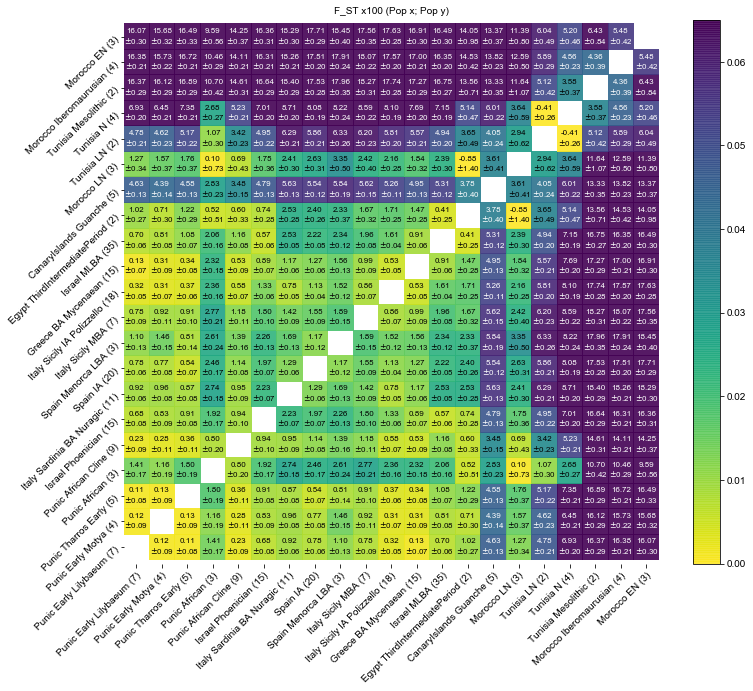

In [40]:
plot_2d(pops=pops_plot, df_fst=df_fst, labels=labels, figsize=(12,10),
        title="F_ST x100 (Pop x; Pop y)", 
        vrange=[0.0, 0.065], fsl=8, fs=10, fs_t=10, mpl=100, full=True, 
        savename="", reverse=True, show_se=True) # ./figs/fst/fst_matrix.pdf

In [23]:
df_pops

,pop,n
0,Punic_African,3
1,Punic_African_Cline,9
2,Israel_Phoenician,15
3,Israel_MLBA,35
4,Spain_IA,20
5,Italy_Sicily_IA_Polizzello,19
6,Italy_Sardinia_EBA,13
7,Greece_BA_Mycenaean,15
8,Italy_Sardinia_BA_Nuragic,11
9,CanaryIslands_Guanche.SG,5
